In [1]:
import os
import numpy as np
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from google.colab import drive

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

images = np.concatenate((train_images, test_images), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

images = images / 255.0
labels = labels.astype(np.int32)

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
def baseline_model():
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(784, activation='relu', kernel_initializer='normal'),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu', kernel_initializer='normal'),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax', kernel_initializer='normal')
        ])
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
        )

    return model


X_train, X_test, y_train, y_test = \
    train_test_split(images, labels, test_size=0.1, random_state=10, stratify=labels)

tf.data.Dataset.from_tensor_slices((X_train, y_train))

<_TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [4]:
model = baseline_model()
model.fit(X_train, y_train, batch_size=64, validation_split=0.2, epochs=30, verbose=1)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Accuracy on test data: {test_acc}')

Epoch 1/30
788/788 [==============================] - 14s 17ms/step - loss: 0.5434 - accuracy: 0.8055 - val_loss: 0.4153 - val_accuracy: 0.8435
Epoch 2/30
788/788 [==============================] - 13s 16ms/step - loss: 0.3995 - accuracy: 0.8547 - val_loss: 0.3751 - val_accuracy: 0.8590
Epoch 3/30
788/788 [==============================] - 12s 16ms/step - loss: 0.3612 - accuracy: 0.8670 - val_loss: 0.3629 - val_accuracy: 0.8663
Epoch 4/30
788/788 [==============================] - 14s 17ms/step - loss: 0.3414 - accuracy: 0.8749 - val_loss: 0.3423 - val_accuracy: 0.8710
Epoch 5/30
788/788 [==============================] - 16s 20ms/step - loss: 0.3262 - accuracy: 0.8789 - val_loss: 0.3406 - val_accuracy: 0.8742
Epoch 6/30
788/788 [==============================] - 13s 17ms/step - loss: 0.3117 - accuracy: 0.8849 - val_loss: 0.3246 - val_accuracy: 0.8817
Epoch 7/30
788/788 [==============================] - 14s 18ms/step - loss: 0.2974 - accuracy: 0.8888 - val_loss: 0.3253 - val_accuracy:

In [5]:
drive.mount('/content/gdrive')

model.save('/content/gdrive/MyDrive/modul18_3/model.keras')

Mounted at /content/gdrive


In [6]:
loaded_model = tf.keras.models.load_model('/content/gdrive/MyDrive/modul18_3/model.keras')

1/1 [==============================] - 0s 31ms/step


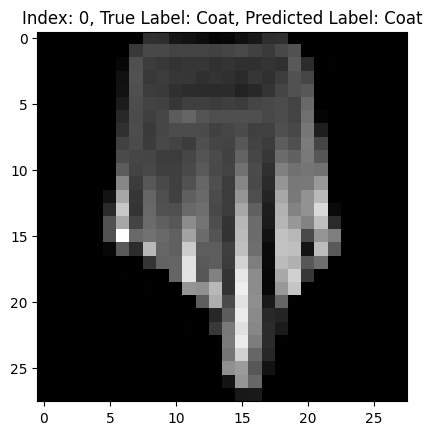

1/1 [==============================] - 0s 22ms/step


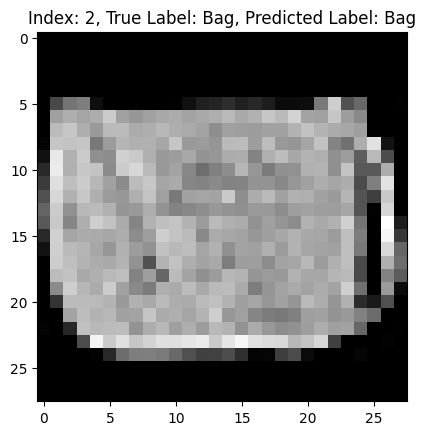

1/1 [==============================] - 0s 20ms/step


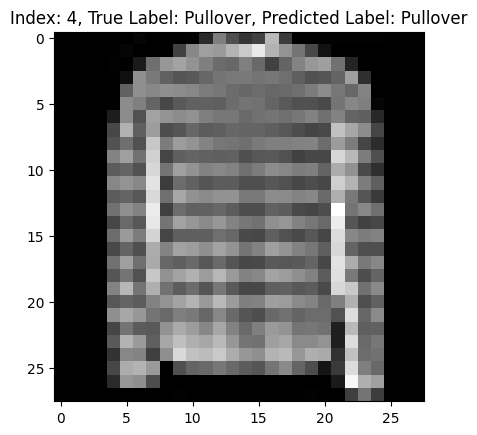

In [26]:
class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}


def predict_and_display(index):
    input_image = X_test[index]
    true_label = y_test[index]

    input_image = np.expand_dims(input_image, axis=0)

    predicted_label = np.argmax(model.predict(input_image))
    predicted_class_name = class_names[predicted_label]
    true_class_name = class_names[true_label]

    plt.imshow(X_test[index], cmap='gray')
    plt.title(f'Index: {index}, True Label: {true_class_name}, Predicted Label: {predicted_class_name}')
    plt.show()


predict_and_display(0)
predict_and_display(2)
predict_and_display(4)

In [27]:
# Funkcja do konwersji i augmentacji obrazów
def augment_images(images, labels, n_repeats=2):
    augmented_images = []
    augmented_labels = []
    transform = A.Compose([
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.Blur(blur_limit=9, p=0.5),
        ], p=1.0),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.8, contrast_limit=0.8, p=0.5)
    ])

    for image, label in zip(images, labels):
        image = (image * 255).astype(np.uint8)

        for _ in range(n_repeats):
            augmented = transform(image=image)
            augmented_images.append(augmented['image'])
            augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)


augmented_X_train, augmented_y_train = augment_images(X_train, y_train)

X_train_augmented = np.concatenate((X_train, augmented_X_train), axis=0)
y_train_augmented = np.concatenate((y_train, augmented_y_train), axis=0)

X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented, random_state=42)

In [28]:
len(X_train_augmented)

189000

In [29]:
model_v2 = baseline_model()
model_v2.fit(X_train_augmented, y_train_augmented, batch_size=128, validation_split=0.2, epochs=30, verbose=1)
test_loss_v2, test_acc_v2 = model_v2.evaluate(X_test, y_test)
print(f'Accuracy on test data: {test_acc_v2}')

Epoch 1/30
1182/1182 [==============================] - 29s 24ms/step - loss: 2.2885 - accuracy: 0.3014 - val_loss: 1.5142 - val_accuracy: 0.4477
Epoch 2/30
1182/1182 [==============================] - 28s 24ms/step - loss: 1.3604 - accuracy: 0.4952 - val_loss: 1.1030 - val_accuracy: 0.5598
Epoch 3/30
1182/1182 [==============================] - 28s 24ms/step - loss: 1.1235 - accuracy: 0.5729 - val_loss: 0.9604 - val_accuracy: 0.6246
Epoch 4/30
1182/1182 [==============================] - 27s 23ms/step - loss: 1.0229 - accuracy: 0.6109 - val_loss: 0.8475 - val_accuracy: 0.6756
Epoch 5/30
1182/1182 [==============================] - 27s 23ms/step - loss: 0.9875 - accuracy: 0.6280 - val_loss: 0.8552 - val_accuracy: 0.6606
Epoch 6/30
1182/1182 [==============================] - 25s 22ms/step - loss: 0.9632 - accuracy: 0.6370 - val_loss: 0.8001 - val_accuracy: 0.6987
Epoch 7/30
1182/1182 [==============================] - 28s 24ms/step - loss: 0.9429 - accuracy: 0.6466 - val_loss: 0.7839 -